In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, time
from PIL import Image
import cv2
import glob
import signal

from IPython import display
%matplotlib inline

# Init cameras
## Get available cameras

In [2]:
def get_cameras(cams=6):
    arr = []
    for index in range(cams):
        print(index)
        cap = cv2.VideoCapture(index)
        if not cap.read()[0]:
            continue
        else:
            arr.append(index)
        cap.release()
    return arr

In [3]:
cid = get_cameras()
cid 

0
1
2
3
4
5


[0, 2, 4]

# Threaded camera reading

In [4]:
from cameras.threaded_cam import Camera


In [5]:
cams = [Camera(i) for i in cid]
ps  = [c.start() for c in cams]


trying to open Camera0
trying to open Camera2
trying to open Camera4
Param::auto exp? 0.25
Param::exp time 0.005002000800320128
Opened Camera2
Param::auto exp? 0.25
Param::exp time 0.005119453924914676
Opened Camera0
Param::auto exp? 0.25
Param::exp time 0.005002000800320128
Opened Camera4


Read 5 frames from Camera0 with ints 123.99058116319445
Read 6 frames from Camera2 with ints 0.8515077039930555
Read 5 frames from Camera4 with ints 0.9349279513888888


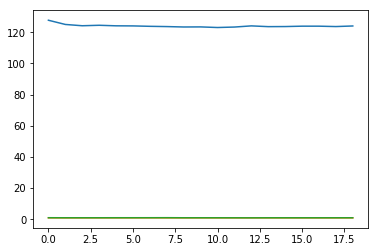

KeyboardInterrupt: 

In [6]:
means = []

while True:
    display.clear_output()
    f, axs = plt.subplots(1,len(cams), figsize=(11,10*len(cams)))
    
    imgs = []
    for c, ax in zip(cams, axs):
        cum, cnt = 0,0
        while not c.buffer.empty():
            im = c.buffer.get() 
            cum += np.mean(im)
            cnt += 1
        mean = cum/cnt
        print(f"Read {cnt} frames from {c.name} with ints {mean}")
        means.append( mean )
        ax.imshow(im)
    plt.pause(0.1)
    f, axs = plt.subplots()
    x = np.array(means)
    x = x.reshape(-1, len(cams)).T
    for l  in x:
        axs.plot(l)
    #display.display(plt.show())
    szs = [ c.buffer.qsize() for c in cams]
    print("buffer sizes:", szs)
plt.show()
        
    

In [12]:
np.array(means).reshape(-1,3).T

array([[218.14586792, 218.07320837, 218.08110352, 218.16104411,
        218.11379042, 218.23175738, 218.16511149, 218.10738336,
        218.05173069, 218.28573907, 218.20976847, 218.12025434,
        218.13404148, 218.01161513, 217.93710113, 218.12428521,
        218.21921748, 218.07602431, 218.03108919, 218.15582791,
        218.14611518, 218.06536241, 217.57208398, 156.37619059,
         27.31824666,  35.17081258, 214.16585015, 218.00924438,
        217.92755968, 218.17398044, 217.768766  , 217.81945692,
        217.83331326, 217.73504666, 217.77115356, 217.94992106],
       [  4.58739134,   4.70016471,   4.76380317,   4.49167144,
          4.70151711,   4.610617  ,   4.71999132,   4.81616102,
          5.10608168,   4.95861093,   4.97510107,   5.18817478,
          5.00025241,   5.22211914,   5.02271141,   5.05062948,
          5.04157371,   4.97998463,   4.90677626,   4.90392768,
          5.01190039,   4.80395955,   4.84882146,   4.81718009,
          4.61619358,   4.74784668,   4

# Graveyard

Below are snippets that can be usefull for tweaking, but most probably are not needed anymore.

This code rests in peace


In [17]:
np.array([1,22,33,5,27,39]).reshape(2,3).T

array([[ 1,  5],
       [22, 27],
       [33, 39]])

In [10]:

#
# Attach interrupt handler to release cameras after sigterm
def release_caps(caps):
    for cap in caps:
        try:
            cap.release()
            print("Released camera")
        except Exception as e:
            print("Error",e)
        
def gen_int_handler(caps):
    def int_handler(signum, frame):
        print("Got sigterm")
        release_caps(caps)
        raise  Exception('Interrupt') 
        #cv2.destroyAllWindows()
    return int_handler

def init_caps(idx_list):
    print(f"Init cameras {idx_list}")
    caps = [cv2.VideoCapture(i) for i in (idx_list) ]

    # Set exposition time-------
    for cap in caps:
        if not cap.isOpened():
            print("Failed to init")
        cap.set(cv2.CAP_PROP_AUTO_EXPOSURE, .25)
        # 10 was found to be the smallest value
        cap.set(cv2.CAP_PROP_EXPOSURE, 0.01)
        print("Param::auto exp?",cap.get(cv2.CAP_PROP_AUTO_EXPOSURE))
        print("Param::exp time", cap.get(cv2.CAP_PROP_EXPOSURE))

    signal.signal(signal.SIGINT, gen_int_handler(caps))
    return caps
caps = init_caps(cid)

Init cameras [0, 2, 4]
Param::auto exp? 0.25
Param::exp time 0.010238907849829351
Param::auto exp? 0.25
Param::exp time 0.010004001600640256
Param::auto exp? 0.25
Param::exp time 0.010004001600640256


In [9]:
release_caps(caps)

Released camera
Released camera
Released camera


In [ ]:

class CameraNoneException(Exception):
    def __init___(self,dErrorArguments):
        Exception.__init__(self,"Camera read None {0}".format(dErrArguments))
        self.dErrorArguments = dErrorArguements
        
        
def read_cameras(caps, idxs, retry_cnt=0):
    results = []
    for camera_idx, cap in zip(idxs,caps):
        print(f"Reading {camera_idx}")
        if cap.isOpened():
            ret, img = cap.read()
        else:
            print("Camera is closed.")
            ret = None
        if not ret:
            print(f"Camera {camera_idx} returned None")

            if retry_cnt<3:
                release_caps(caps)
                time.sleep(0.1)
                print(f"Trying to connect to {camera_idx} only")
                cap_retry = init_caps([camera_idx])
                time.sleep(0.1)
                res_retry = read_cameras(cap_retry, [camera_idx], retry_cnt=retry_cnt+1)
                results += res_retry
            else:
                print(f"!>>\nCamera {camera_idx} is not working at all")
                continue
        else:
            results.append(img)
    return results

while True:
    display.clear_output()
    results = read_cameras(caps, cid)
    print(len(results))
    for res in results:
        plt.imshow(res)
        plt.show()
        plt.close()
    time.sleep(0.5)


In [ ]:
# Main loop

while True:
    for camera_idx, cap in zip(cams_idxs,caps):
        ret, img = cap.read()
        if not ret:
            print(f"Camera {camera_idx} returned None")
            print("Releasing all cameras and trying this camera only")
    if (tries==retry_cnt):
        print("Camera %i is not working. Giving up."%num)
        print()
        break
    time.sleep(retry_sec)


In [ ]:
import cv2
import threading
import time
# Threaded camera reader

class camThread(threading.Thread):
    def __init__(self, img_array, camID, cap):
        threading.Thread.__init__(self)
        self.camID = camID
        self.cap = cap
        self.array = img_array
    def run(self):t
        print ("Starting %s"% self.camID)
        if self.cap.isOpened():  # try to get the first frame
            rval, frame = self.cap.read()
            time.sleep(0)
            if not rval:
                print("fail", self.camID)
                frames = read

        #pic = take_pic(self.camID)
            self.array.append(frame)
        else:
            print("fail")

def take_pic(camID):
    cam = cv2.VideoCapture(camID)
    if cam.isOpened():  # try to get the first frame
        time.sleep(0)
        rval, frame = cam.read()
        time.sleep(0)
        print('read')
        return frame
    else:
        rval = False

# Create two threads as follows
a = []
b = []

thread1 = camThread(a, 0, caps[0])
thread2 = camThread(b, 2, caps[1])
thread1.start()
thread2.start()

In [ ]:
# a library of some unknown buddy from stackoverflow
import cvpubsubs.webcam_pub as w
from cvpubsubs.window_sub import SubscriberWindows

t1 = w.VideoHandlerThread(0)
t2 = w.VideoHandlerThread(2)
t3 = w.VideoHandlerThread(3)

t1.start()
t2.start()
t3.start()

SubscriberWindows(window_names=['cammy', 'cammy2','cam3'],
              video_sources=[0,2,3]
              ).loop()

t1.join()
t2.join()
t3.join()